# RNA-seq of heterozygous vs knock-out Gm15441-KO livers.

In [2]:
suppressPackageStartupMessages({
    library('DESeq2')
    library('pheatmap')
    library('stringr')
    library('dplyr')
    library('tibble')
    library('ggplot2')
    library('clusterProfiler')
    library('biomaRt')
})

In [2]:
# Custom function to plot GO enrichment results
plotGo <- function(go, n_terms=20, ...) {
    #' Params:
    #'   @go: enrichment result; direct output of the enrichGO function.
    #'        It is not the dataframe located in the slot @result.
    #'   @n_terms: number of enrichment terms to show
    
    require('ggplot2')
    df <- go@result %>% slice(1:n_terms)
    
    ggplot(df, aes(Count, Description)) +
    geom_col(aes(fill=p.adjust)) + 
    scale_fill_gradient(trans='reverse')
}

In [5]:
counts <- read.csv('data/hts_counts.csv', header=T, row.names=1)
header <- paste0('SM', 4393:4402)
colnames(counts) <- header
# Keep only heterozygous and KO
keep_cols <- header[c(1, 2, 6, 3:5)]
counts <- counts[str_detect(rownames(counts), '__', negate=T), keep_cols]
condition <- factor(c(rep('het', 3), rep('ko', 3)), levels=c('het', 'ko'))
design <- data.frame(condition=condition, row.names=keep_cols)
dds <- DESeqDataSetFromMatrix(counts, design, ~condition)
dds <- DESeq(dds, quiet=T)
res <- results(dds)
res <- res[order(res$padj), ]
res <- rownames_to_column(as.data.frame(res), 'ensembl') %>% as_tibble()

In [5]:
# Add gene symbols to the results table
ensembl <- useMart('ensembl', dataset='mmusculus_gene_ensembl')
gen_symbols <- getBM(attributes=c('mgi_symbol', 'ensembl_gene_id'), values=rownames(res), mart=ensembl)
res <- left_join(res, gen_symbols, by=c('ensembl' = 'ensembl_gene_id'))
#write_csv2(res, 'data/results/deseq2_het-ko.csv')
sig_res <- filter(res, padj < 0.05)

## Top-20 differentially expressed genes

In [6]:
sig_res[1:20, ]

[1] Top-20 differentially expressed genes


ensembl            baseMean    log2FoldChange lfcSE     stat     
1  ENSMUSG00000096674   874.14208  5.909337      0.3222703 18.336586
2  ENSMUSG00000078675  1934.16512  5.570725      0.3310133 16.829309
3  ENSMUSG00000078686   224.35059  6.436374      0.4686397 13.734162
4  ENSMUSG00000020000   675.90177  3.979870      0.3099877 12.838800
5  ENSMUSG00000073830  5833.08869  3.686748      0.2933975 12.565708
6  ENSMUSG00000073842 36764.04734  3.306931      0.2828751 11.690425
7  ENSMUSG00000074398    83.09210 -3.822820      0.4037798 -9.467587
8  ENSMUSG00000068877   821.94949  3.129765      0.3447867  9.077396
9  ENSMUSG00000096688  9587.89778  6.090814      0.7304673  8.338243
10 ENSMUSG00000027346  1966.54678  2.459587      0.3012828  8.163716
11 ENSMUSG00000089873    50.21144  4.830503      0.6105868  7.911247
12 ENSMUSG00000042225   714.79416 -2.499895      0.3364445 -7.430333
13 ENSMUSG00000038092   129.89471  2.374033      0.3298398  7.197534
14 ENSMUSG00000049404   639.77130  2.624807      0.3678331  7.135864
15 ENSMUSG00000033107   474.70496  2.322221      0.3373804  6.883094
16 ENSMUSG00000090090    55.79441  3.642570      0.5295511  6.878600
17 ENSMUSG00000024899  1545.65173  1.495491      0.2193673  6.817293
18 ENSMUSG00000078673    37.03991  3.454636      0.5093191  6.782852
19 ENSMUSG00000028240  2017.32013  1.757346      0.2614723  6.720965
20 ENSMUSG00000081207    32.91567  3.568576      0.5350892  6.669124
   pvalue       padj         mgi_symbol
1  4.225106e-75 6.601729e-71 Mup15     
2  1.488277e-63 1.162717e-59 Mup16     
3  6.338489e-43 3.301296e-39 Mup9      
4  9.940359e-38 3.882953e-34 Moxd1     
5  3.259432e-36 1.018572e-32 Mup14     
6  1.426717e-31 3.715408e-28 Mup7      
7  2.863831e-21 6.392480e-18 Gm15441   
8  1.112034e-19 2.171942e-16 Selenbp2  
9  7.540246e-17 1.309070e-13 Mup17     
10 3.248725e-16 5.076133e-13 Gpcpd1    
11 2.548230e-15 3.619645e-12 Mup13     
12 1.083244e-13 1.410474e-10 Ammecr1   
13 6.131134e-13 7.369151e-10 Hsd3b5    
14 9.618133e-13 1.073452e-09 Rarres1   
15 5.856633e-12 5.902717e-09 Rnf125    
16 6.044382e-12 5.902717e-09 Mup-ps16  
17 9.277189e-12 8.526828e-09 Papss2    
18 1.178261e-11 1.022796e-08 Mup19     
19 1.805251e-11 1.484581e-08 Cyp7a1    
20 2.573342e-11 2.010424e-08 Gm13775

## Heatmap of differentially expressed genes

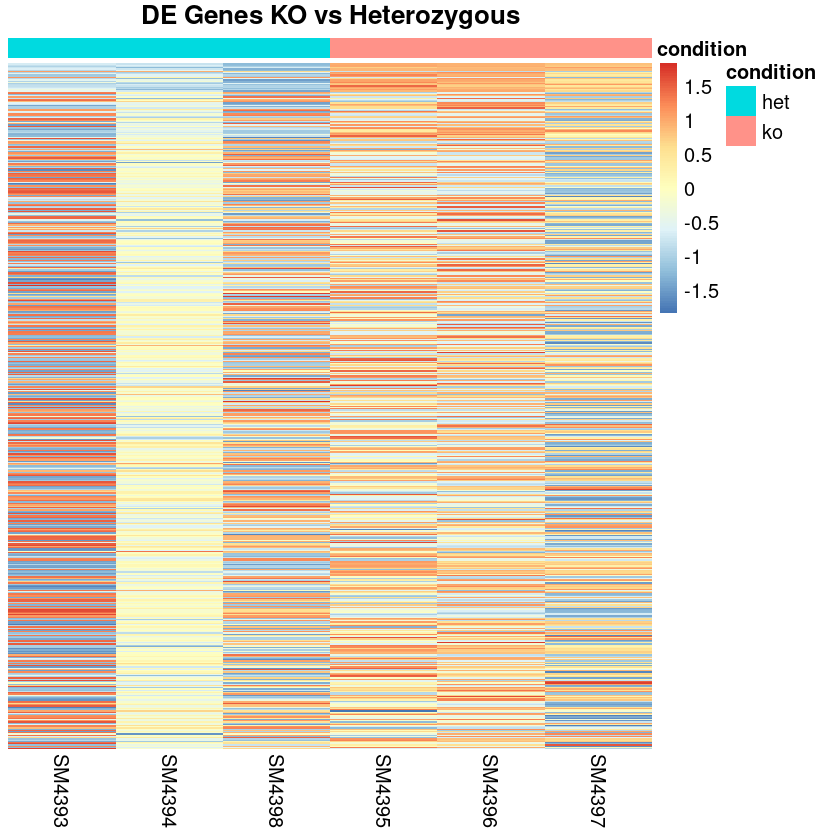

In [4]:
# Get the log2 + 1 of counts
norm_cts <- normTransform(dds)
# Heatmap of DGE genes
#svg('imgs/hmap_sig_het-ko.svg')
pheatmap(
    assay(norm_cts)[sig_res$ensembl, ],
    cluster_rows=F,
    cluster_cols=F,
    show_rownames=F,
    annotation_col=design,
    main='DE Genes KO vs Heterozygous',
    fontsize=12,
    scale='row'
)
#dev.off()

## Principal component analysis

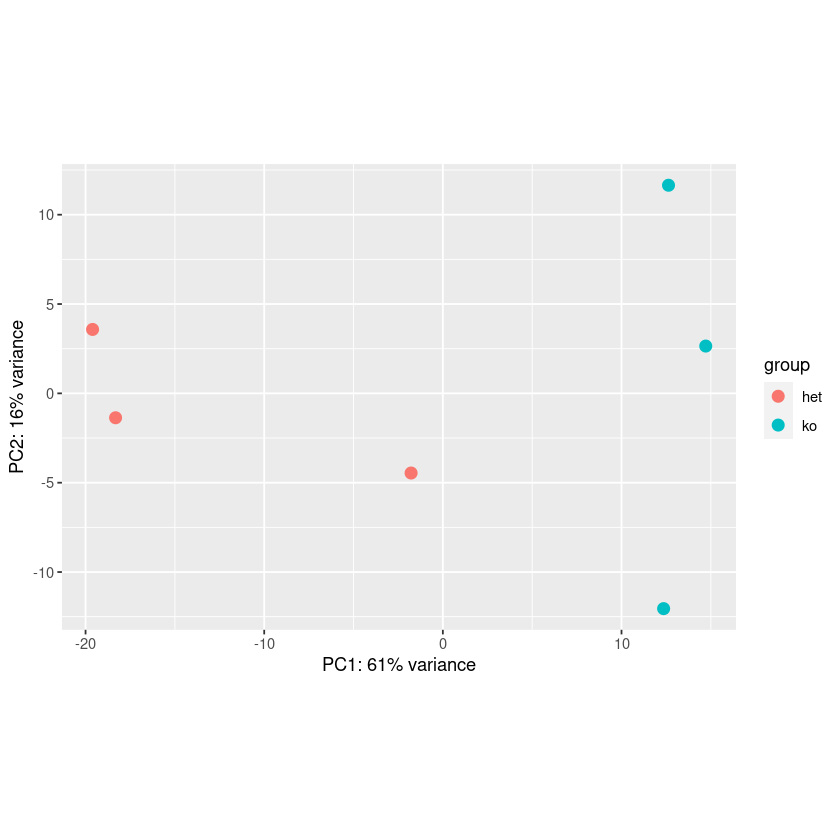

In [5]:
#svg('imgs/pca_het-ko.svg')
vsd <- vst(dds, blind=F)
plotPCA(vsd, intgroup='condition')
#dev.off()

## MA plot

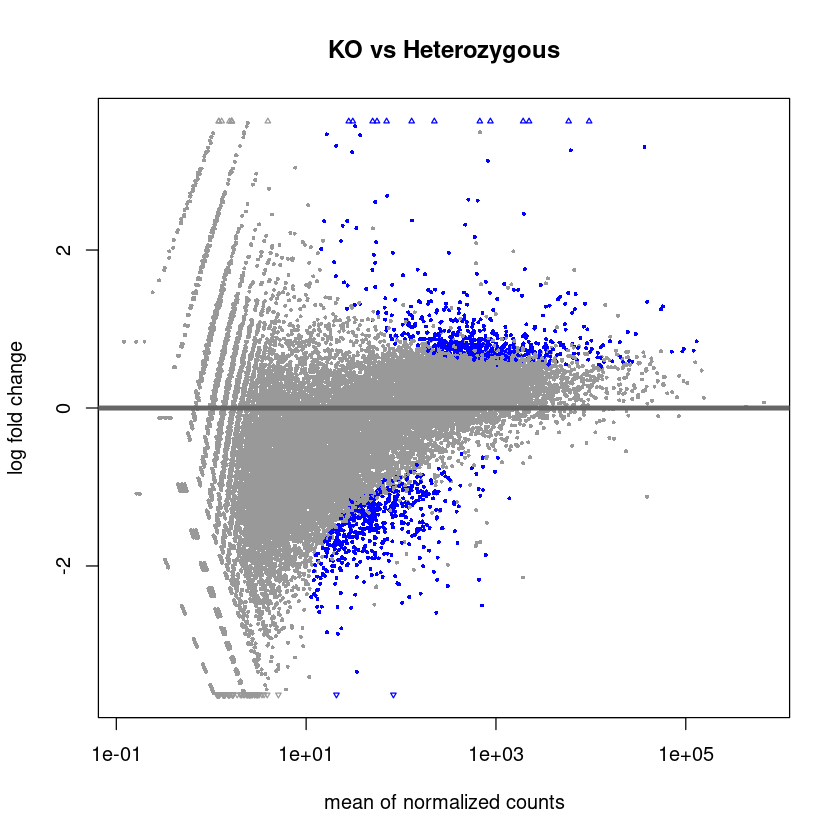

In [6]:
#svg('imgs/ma_het-ko.svg')
plotMA(results(dds), main='KO vs Heterozygous')
#dev.off()

## Enrichment of up-regulated genes

Loading required package: org.Mm.eg.db

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:clusterProfiler’:

    select


The following object is masked from ‘package:dplyr’:

    select






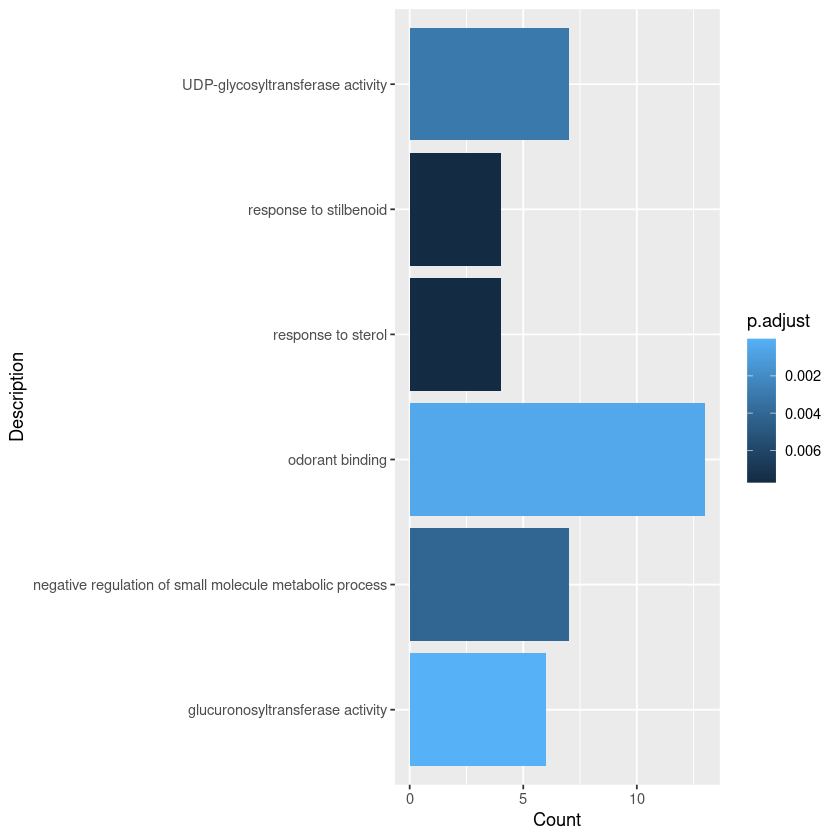

In [8]:
# Gene enrichment analysis
up_gen <- filter(sig_res, log2FoldChange >= 1) %>% pull('ensembl')
down_gen <- filter(sig_res, log2FoldChange <= -1) %>% pull('ensembl')
ego_up <- enrichGO(
    gene=up_gen,
    universe=res$ensembl,
    ont='ALL',
    pAdjustMethod='BH',
    pvalueCutoff=0.01,
    qvalueCutoff=0.05,
    OrgDb='org.Mm.eg.db',
    keyType='ENSEMBL'
)
enrich_up <- ego_up@result
enrich_up <- enrich_up[order(enrich_up$p.adjust), ]
#write_csv2(enrich_up, 'data/results/go_het-ko_up.csv')
#svg('imgs/go_up_het-ko.svg')
plotGo(ego_up)
#dev.off()

## Enrichment of down-regulated genes

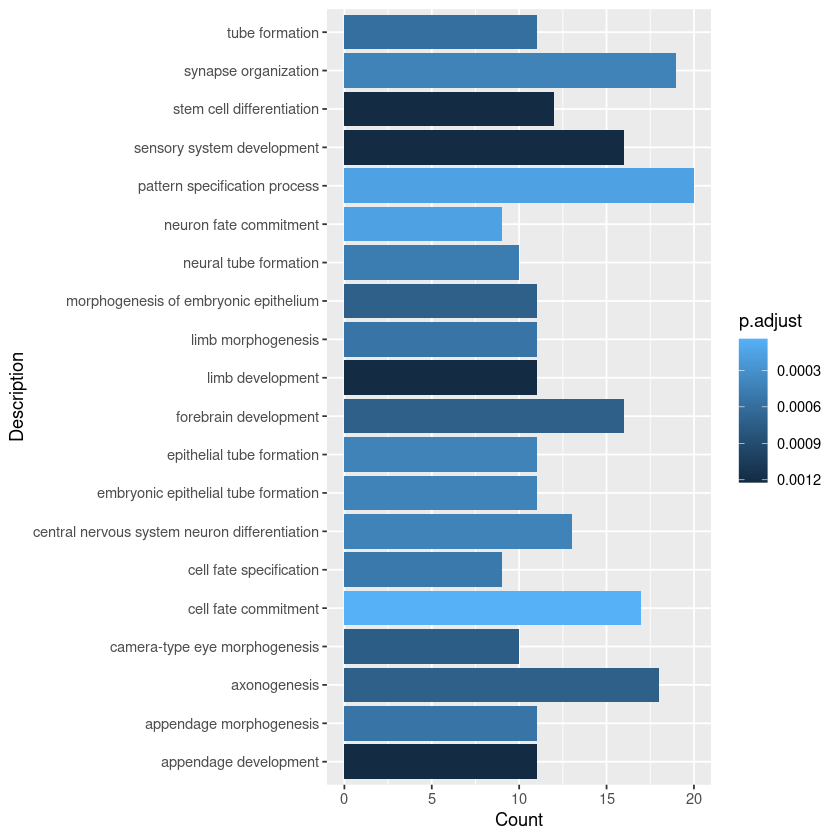

In [9]:
ego_down <- enrichGO(
    gene=down_gen,
    universe=res$ensembl,
    ont='ALL',
    pAdjustMethod='BH',
    pvalueCutoff=0.01,
    qvalueCutoff=0.05,
    OrgDb='org.Mm.eg.db',
    keyType='ENSEMBL'
)
enrich_down <- ego_down@result
enrich_down <- enrich_down[order(enrich_down$p.adjust), ]
#write_csv2(enrich_down, 'data/results/go_het-ko_down.csv')
#svg('imgs/go_down_het-ko.svg')
plotGo(ego_down)
#dev.off()

In [10]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=sv_SE.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=da_DK.UTF-8        LC_COLLATE=sv_SE.UTF-8    
 [5] LC_MONETARY=da_DK.UTF-8    LC_MESSAGES=sv_SE.UTF-8   
 [7] LC_PAPER=da_DK.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=da_DK.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] org.Mm.eg.db_3.12.0         AnnotationDbi_1.52.0       
 [3] biomaRt_2.46.3              clusterProfiler_3.18.1     
 [5] ggplot2_3.3.3               tibble_3.1.0               
 [7] dplyr_1.0.5                 stringr_1.4.0              
